# Nested rejection sampling

This example demonstrates how to use nested rejection sampling [1] to sample from the posterior distribution for a logistic model fitted to model-simulated data.

[1] "Nested Sampling for General Bayesian Computation", John Skilling, Bayesian Analysis (2006) [https://projecteuclid.org/download/pdf_1/euclid.ba/1340370944](https://projecteuclid.org/download/pdf_1/euclid.ba/1340370944).

First create fake data.

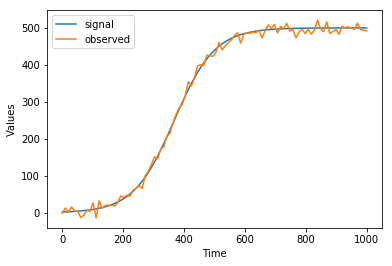

In [1]:
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
r = 0.015
k = 500
real_parameters = [r, k]
times = np.linspace(0, 1000, 100)
signal_values = model.simulate(real_parameters, times)

# Add independent Gaussian noise
sigma = 10
observed_values = signal_values + pints.noise.independent(sigma, signal_values.shape)

# Plot
plt.plot(times,signal_values,label = 'signal')
plt.plot(times,observed_values,label = 'observed')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

Create the nested sampler that will be used to sample from the posterior.

In [2]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, observed_values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, sigma * 0.5],
    [0.02, 600, sigma * 1.5])

# Create a nested ellipsoidal rejectection sampler
sampler = pints.NestedController(log_likelihood, log_prior, method=pints.NestedRejectionSampler)

# Set number of iterations
sampler.set_iterations(3000)

# Set the number of posterior samples to generate
sampler.set_n_posterior_samples(300)

Run the sampler!

In [3]:
samples = sampler.run()
print('Done!')

Running Nested rejection sampler
Number of active points: 400
Total number of iterations: 3000
Total number of posterior samples: 300
Iter. Eval. Time m:s Delta_log(z) Acceptance rate
0     1       0:00.0 -inf          1             
0     2       0:00.0 -inf          1             
0     3       0:00.0 -inf          1             
0     4       0:00.0 -inf          1             
0     5       0:00.0 -inf          1             
0     21      0:00.0 -inf          1             
0     41      0:00.0 -inf          1             
0     61      0:00.0 -inf          1             
0     81      0:00.0 -inf          1             
0     101     0:00.0 -inf          1             
0     121     0:00.0 -inf          1             
0     141     0:00.0 -inf          1             
0     161     0:00.0 -inf          1             
0     181     0:00.0 -inf          1             
0     201     0:00.0 -inf          1             
0     221     0:00.0 -inf          1             
0     241     0:

3120  344318   0:25.3 -11.81921123  0.00791176967 
3140  361042   0:26.6 -11.50068327  0.00760033496 
3160  385384   0:28.3 -11.17973559  0.00717172662 
3180  405766   0:29.9 -10.87044814  0.00686046684 
3200  424583   0:31.2 -10.57561585  0.00660328207 
3220  443997   0:32.6 -10.29395687  0.00635937574 
3240  465671   0:34.1 -10.02363379  0.0061061188  
3260  502610   0:36.5 -9.761689292  0.00569682006 
3280  533955   0:39.9 -9.51380195   0.00539963078 
3300  561363   0:44.4 -9.262129401  0.00517146407 
3320  583595   0:47.8 -9.010319581  0.00500861633 
3340  606771   0:50.7 -8.756313857  0.00485016599 
3360  638113   0:52.9 -8.505060223  0.00464315452 
3380  676699   0:55.7 -8.26001054   0.0044078137  
Done!


## Plot posterior samples versus true parameter values (dashed lines)

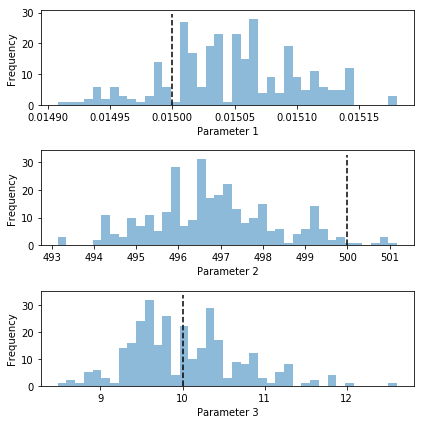

In [4]:
# Plot output
import pints.plot

pints.plot.histogram([samples], ref_parameters=[r, k, sigma])

plt.show()

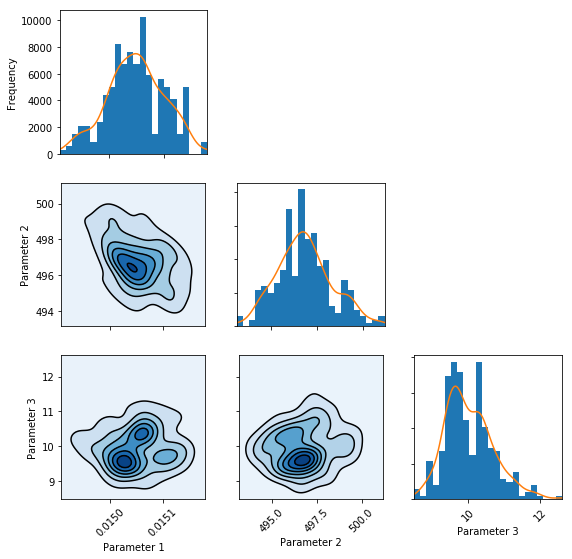

In [5]:
vTheta = samples[0]
pints.plot.pairwise(samples, kde=True)

plt.show()

## Plot posterior predictive simulations versus the observed data

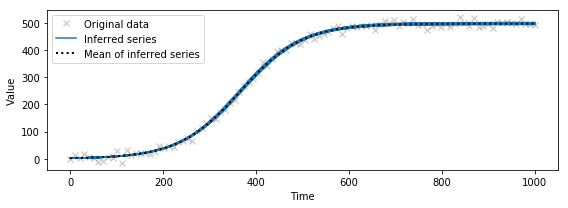

In [6]:
pints.plot.series(samples[:100], problem)
plt.show()

## Marginal likelihood estimate

In [7]:
print('marginal log-likelihood = ' + str(sampler.marginal_log_likelihood())
      + ' ± ' + str(sampler.marginal_log_likelihood_standard_deviation()))

marginal log-likelihood = -380.366432957 ± 0.0806002449976


## Examine active and inactive points at end of sampling run

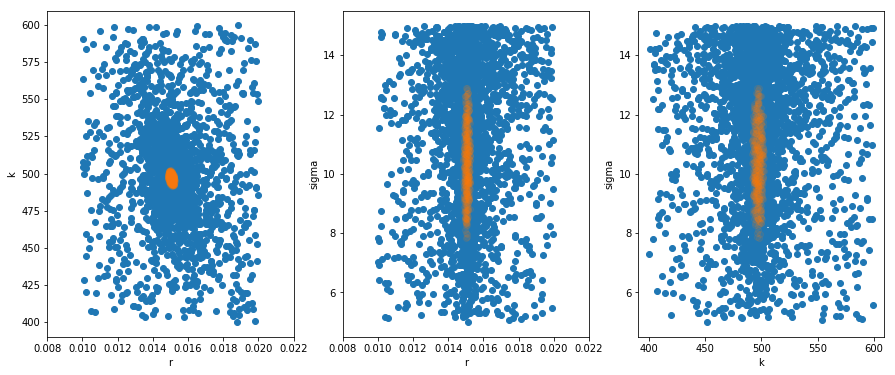

In [8]:
m_active = sampler.active_points()
m_inactive = sampler.inactive_points()

f, axarr = plt.subplots(1,3,figsize=(15,6))
axarr[0].scatter(m_inactive[:,0],m_inactive[:,1])
axarr[0].scatter(m_active[:,0],m_active[:,1],alpha=0.1)
axarr[0].set_xlim([0.008,0.022])
axarr[0].set_xlabel('r')
axarr[0].set_ylabel('k')
axarr[1].scatter(m_inactive[:,0],m_inactive[:,2])
axarr[1].scatter(m_active[:,0],m_active[:,2],alpha=0.1)
axarr[1].set_xlim([0.008,0.022])
axarr[1].set_xlabel('r')
axarr[1].set_ylabel('sigma')
axarr[2].scatter(m_inactive[:,1],m_inactive[:,2])
axarr[2].scatter(m_active[:,1],m_active[:,2],alpha=0.1)
axarr[2].set_xlabel('k')
axarr[2].set_ylabel('sigma')
plt.show()

## Examine log-likelihoods versus proportion of prior space sampled

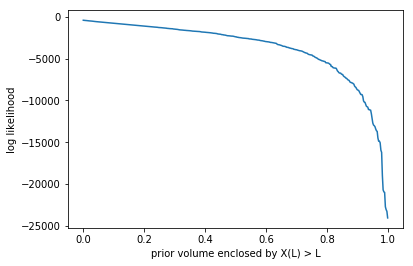

In [9]:
v_log_likelihood = sampler.log_likelihood_vector()
v_log_likelihood = v_log_likelihood[:-sampler._sampler.n_active_points()]
X = sampler.prior_space()
X = X[:-1]
plt.plot(X, v_log_likelihood)
plt.xlabel('prior volume enclosed by X(L) > L')
plt.ylabel('log likelihood')
plt.show()

## Sample some other posterior samples from recent run

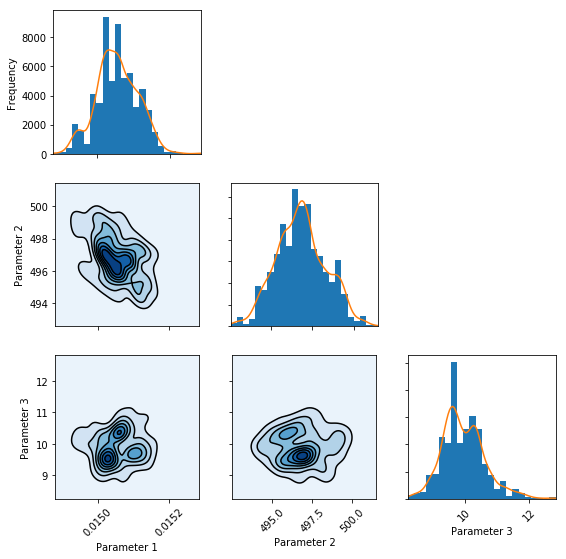

In [10]:
samples_new = sampler.sample_from_posterior(1000)

pints.plot.pairwise(samples_new, kde=True)

plt.show()